# Imports and setup

### Auto-re-import python modules, useful for editing local fils

In [4]:
%load_ext autoreload
%autoreload 2

## Imports

In [37]:
import itertools
import warnings
from collections import Counter

import matplotlib as mpl
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm

pd.options.display.max_columns = 100

mpl.rcParams["figure.max_open_warning"] = 0

In [6]:
assert pl.__version__ == "1.9.0"

# Read in data

In [7]:
analysis_outdir = (
    "s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__protein_k5-20"
)

### ~Explore with protein, k=7~

In [8]:
# Skip ksizes 5 and 6 for now because those files are enormous, 2.3 GiB for k=5 and 175 MiB for k=6
# -> Figure out how to use polars later
ksizes = range(7, 21)

In [9]:
ksize = 7
# pq = make_multisearch_pq(ksize, analysis_outdir, "protein")
# multisearch = pd.read_parquet(pq)
# print(multisearch.shape)
# multisearch.head()

In [10]:
lineage_cols = ["family", "superfamily", "fold", "class"]

## Explore with hp, ksize=20

In [11]:
! aws s3 ls s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__hp_k20-60/00_cleaned_multisearch_results/

2024-10-11 18:16:03  148970746 scope40.multisearch.hp.k20.filtered.pq
2024-10-11 18:15:59  266528288 scope40.multisearch.hp.k20.pq
2024-10-11 18:16:58   73471226 scope40.multisearch.hp.k21.filtered.pq
2024-10-11 18:16:55  131280255 scope40.multisearch.hp.k21.pq
2024-10-11 18:17:27   37211776 scope40.multisearch.hp.k22.filtered.pq
2024-10-11 18:17:25   67829683 scope40.multisearch.hp.k22.pq
2024-10-11 18:17:39   19593596 scope40.multisearch.hp.k23.filtered.pq
2024-10-11 18:17:38   35583004 scope40.multisearch.hp.k23.pq
2024-10-11 18:17:47   10651873 scope40.multisearch.hp.k24.filtered.pq
2024-10-11 18:17:46   19449323 scope40.multisearch.hp.k24.pq
2024-10-11 18:17:51    5893593 scope40.multisearch.hp.k25.filtered.pq
2024-10-11 18:17:50   11495754 scope40.multisearch.hp.k25.pq
2024-10-11 18:17:54    3262063 scope40.multisearch.hp.k26.filtered.pq
2024-10-11 18:17:53    7462970 scope40.multisearch.hp.k26.pq
2024-10-11 18:17:56    2171794 scope40.multisearch.hp.k27.filtered.pq
2024-10-11 18

In [12]:
! aws s3 ls s3://seanome-kmerseek/scope-benchmark/analysis-outputs/

                           PRE 2024-10-09__hp_k20-60/
                           PRE 2024-10-09__protein_k5-20/


In [13]:
# ! aws s3 ls s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__protein_k5-20/00_cleaned_multisearch_results/

In [14]:
# def make_multisearch_pq(
#     ksize,
#     outdir,
#     moltype,
# ):
#     basename = f"scope40.multisearch.{moltype}.k{ksize}.pq"
#     pq = f"{outdir}/00_cleaned_multisearch_results/{basename}"
#     return pq


pq = "s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__hp_k20-60/00_cleaned_multisearch_results/scope40.multisearch.hp.k20.filtered.pq"
multisearch = pl.read_parquet(pq)
multisearch = multisearch.with_columns(
    pl.col("prob_overlap_adjusted").pow(-1).alias("prob_overlap_adjusted_inverse")
)
multisearch = multisearch.with_columns(
    pl.col("prob_overlap_adjusted").log10().alias("prob_overlap_adjusted_log10")
)
multisearch = multisearch.with_columns(
    pl.col("containment").log10().alias("containment_log10")
)
multisearch = multisearch.with_columns(
    pl.col("max_containment").log10().alias("max_containment_log10")
)
multisearch = multisearch.with_columns(
    pl.col("tf_idf_score").log10().alias("tf_idf_score_log10")
)
print(multisearch.shape)
multisearch.head()

/tmp/ipykernel_24891/3032863786.py:12: UserWarning: '(default_)region' not set; polars will try to get it from bucket

Set the region manually to silence this warning.
  multisearch = pl.read_parquet(pq)


(1761706, 37)


query_name,query_md5,match_name,match_md5,containment,max_containment,jaccard,intersect_hashes,prob_overlap,prob_overlap_adjusted,containment_adjusted,containment_adjusted_log10,tf_idf_score,query_scop_id,query_scop_lineage,query_scop_lineage_fixed,query_family,query_superfamily,query_fold,query_class,match_scop_id,match_scop_lineage,match_scop_lineage_fixed,match_family,match_superfamily,match_fold,match_class,same_family,same_superfamily,same_fold,same_class,__index_level_0__,prob_overlap_adjusted_inverse,prob_overlap_adjusted_log10,containment_log10,max_containment_log10,tf_idf_score_log10
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,cat,cat,cat,cat,str,str,str,cat,cat,cat,cat,bool,bool,bool,bool,i64,f64,f64,f64,f64,f64
"""d2fcwa1 a.13.1.1 (A:216-320) a…","""e6ac707cdd74e7c0bdffe2ec104b1c…","""d4j42a_ a.25.3.0 (A:) automate…","""429b50d612d737b387bab434a8ff53…",0.034884,0.04918,0.020833,3.0,1.7368e-11,0.004001,8.71974,0.940504,0.303089,"""d2fcwa1""","""a.13.1.1""","""a.13.1.1""","""a.13.1.1""","""a.13.1""","""a.13""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,false,true,2,249.965886,-2.397881,-1.457377,-1.308209,-0.518429
"""d6d5xa_ a.25.2.0 (A:) automate…","""ad230364a72799163d9e8eb34d3f41…","""d4j42a_ a.25.3.0 (A:) automate…","""429b50d612d737b387bab434a8ff53…",0.028169,0.065574,0.020101,4.0,1.9894e-11,0.004582,6.14716,0.788675,0.247069,"""d6d5xa_""","""a.25.2.0""","""a.25.2.0""","""a.25.2.0""","""a.25.2""","""a.25""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,true,true,3,218.224186,-2.338903,-1.550228,-1.18327,-0.607181
"""d4dlla2 a.100.1.0 (A:191-316) …","""892f25011eb07e4a98cf99b6a5785b…","""d4j42a_ a.25.3.0 (A:) automate…","""429b50d612d737b387bab434a8ff53…",0.018692,0.032787,0.012048,2.0,7.1051e-12,0.001637,11.421079,1.057707,0.167505,"""d4dlla2""","""a.100.1.0""","""a.100.1.0""","""a.100.1.0""","""a.100.1""","""a.100""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,false,true,8,611.027722,-2.786061,-1.728354,-1.4843,-0.775973
"""d1n4ka1 a.118.22.1 (A:436-602)…","""5a73d8ef1d497161dda842a31cb621…","""d4j42a_ a.25.3.0 (A:) automate…","""429b50d612d737b387bab434a8ff53…",0.027027,0.065574,0.019512,4.0,2.1315e-11,0.00491,5.504754,0.740738,0.235821,"""d1n4ka1""","""a.118.22.1""","""a.118.22.1""","""a.118.22.1""","""a.118.22""","""a.118""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,false,true,12,203.675907,-2.30894,-1.568202,-1.18327,-0.627417
"""d6s7ja_ a.127.1.0 (A:) automat…","""63a7a4cd3cb81a25bf7cd92c5674fc…","""d4j42a_ a.25.3.0 (A:) automate…","""429b50d612d737b387bab434a8ff53…",0.004184,0.032787,0.003724,2.0,8.2103e-12,0.001891,2.212443,0.344872,0.037029,"""d6s7ja_""","""a.127.1.0""","""a.127.1.0""","""a.127.1.0""","""a.127.1""","""a.127""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,false,true,15,528.77399,-2.72327,-2.378398,-1.4843,-1.431458


## I want to compare all the metrics for these different classes

In [15]:
multisearch.shape

(1761706, 37)

In [16]:
same_lineage_cols = [f"same_{x}" for x in lineage_cols]


multisearch_melt_scop_levels = multisearch.unpivot(
    index=["query_name", "match_name"],
    on=same_lineage_cols,
    variable_name="scop_level",
    value_name="is_same",
)
multisearch_melt_scop_levels = multisearch_melt_scop_levels.with_columns(
    pl.col("scop_level").str.split("_").list.last().alias("scop_level")
)
print(multisearch_melt_scop_levels.shape)
multisearch_melt_scop_levels.head()

(7046824, 4)


query_name,match_name,scop_level,is_same
str,str,str,bool
"""d2fcwa1 a.13.1.1 (A:216-320) a…","""d4j42a_ a.25.3.0 (A:) automate…","""family""",false
"""d6d5xa_ a.25.2.0 (A:) automate…","""d4j42a_ a.25.3.0 (A:) automate…","""family""",false
"""d4dlla2 a.100.1.0 (A:191-316) …","""d4j42a_ a.25.3.0 (A:) automate…","""family""",false
"""d1n4ka1 a.118.22.1 (A:436-602)…","""d4j42a_ a.25.3.0 (A:) automate…","""family""",false
"""d6s7ja_ a.127.1.0 (A:) automat…","""d4j42a_ a.25.3.0 (A:) automate…","""family""",false


### Get value columns

In [17]:
value_cols = [
    col
    for col, dtype in zip(multisearch.columns, multisearch.dtypes)
    if isinstance(dtype, pl.Float64)
]
value_cols

['containment',
 'max_containment',
 'jaccard',
 'intersect_hashes',
 'prob_overlap',
 'prob_overlap_adjusted',
 'containment_adjusted',
 'containment_adjusted_log10',
 'tf_idf_score',
 'prob_overlap_adjusted_inverse',
 'prob_overlap_adjusted_log10',
 'containment_log10',
 'max_containment_log10',
 'tf_idf_score_log10']

In [1]:
value_cols_filtered = [
    # "containment",
    "containment_log10",
    # "max_containment",
    "max_containment_log10",
    "jaccard",
    "intersect_hashes",
    # "prob_overlap",
    # "prob_overlap_adjusted",
    # "containment_adjusted",
    "containment_adjusted_log10",
    # "tf_idf_score",
    "tf_idf_score_log10",
    # "prob_overlap_adjusted_inverse",
    "prob_overlap_adjusted_log10",
]
value_cols_filtered

['containment_log10',
 'max_containment_log10',
 'jaccard',
 'intersect_hashes',
 'containment_adjusted_log10',
 'tf_idf_score_log10',
 'prob_overlap_adjusted_log10']

In [23]:
multisearch_melt_sourmash_score = multisearch.unpivot(
    index=["query_name", "match_name"],
    on=value_cols_filtered,
    variable_name="sourmash_score",
    value_name="score_value",
)
print(multisearch_melt_sourmash_score.shape)
multisearch_melt_sourmash_score.head()

(12331942, 4)


query_name,match_name,sourmash_score,score_value
str,str,str,f64
"""d2fcwa1 a.13.1.1 (A:216-320) a…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.457377
"""d6d5xa_ a.25.2.0 (A:) automate…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.550228
"""d4dlla2 a.100.1.0 (A:191-316) …","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.728354
"""d1n4ka1 a.118.22.1 (A:436-602)…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.568202
"""d6s7ja_ a.127.1.0 (A:) automat…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-2.378398


In [24]:
multisearch_melt_combined = multisearch_melt_sourmash_score.join(
    multisearch_melt_scop_levels, on=["query_name", "match_name"]
)

multisearch_melt_combined

query_name,match_name,sourmash_score,score_value,scop_level,is_same
str,str,str,f64,str,bool
"""d2fcwa1 a.13.1.1 (A:216-320) a…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.457377,"""family""",false
"""d2fcwa1 a.13.1.1 (A:216-320) a…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.457377,"""superfamily""",false
"""d2fcwa1 a.13.1.1 (A:216-320) a…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.457377,"""fold""",false
"""d2fcwa1 a.13.1.1 (A:216-320) a…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.457377,"""class""",true
"""d6d5xa_ a.25.2.0 (A:) automate…","""d4j42a_ a.25.3.0 (A:) automate…","""containment_log10""",-1.550228,"""family""",false
…,…,…,…,…,…
"""d3ja861 b.40.4.11 (6:103-463) …","""d3ryca1 c.32.1.1 (A:1-245) aut…","""prob_overlap_adjusted_log10""",-2.251753,"""class""",false
"""d3qfta1 b.43.4.1 (A:246-521) a…","""d3ryca1 c.32.1.1 (A:1-245) aut…","""prob_overlap_adjusted_log10""",-2.740303,"""family""",false
"""d3qfta1 b.43.4.1 (A:246-521) a…","""d3ryca1 c.32.1.1 (A:1-245) aut…","""prob_overlap_adjusted_log10""",-2.740303,"""superfamily""",false


--- ('containment_adjusted_log10',) ---
(7046824, 6)
--- ('jaccard',) ---
(7046824, 6)
--- ('tf_idf_score_log10',) ---
(7046824, 6)
--- ('containment_log10',) ---
(7046824, 6)
--- ('intersect_hashes',) ---
(7046824, 6)
--- ('max_containment_log10',) ---
(7046824, 6)
--- ('prob_overlap_adjusted_log10',) ---
(7046824, 6)


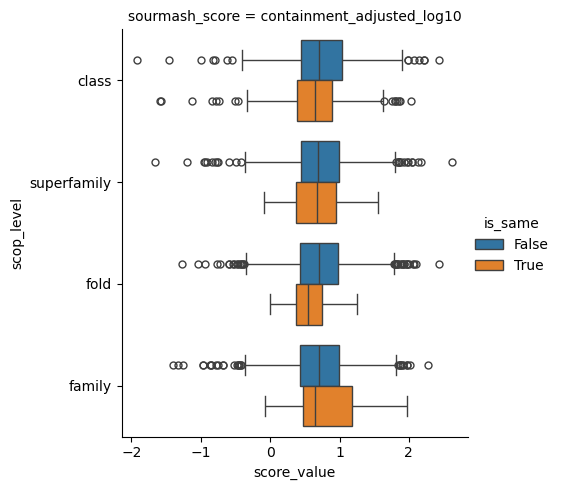

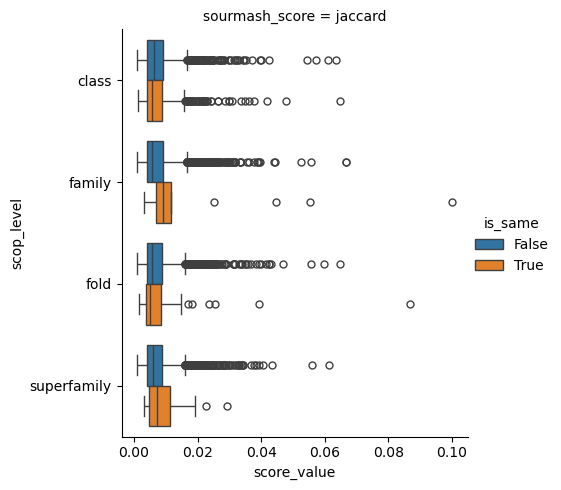

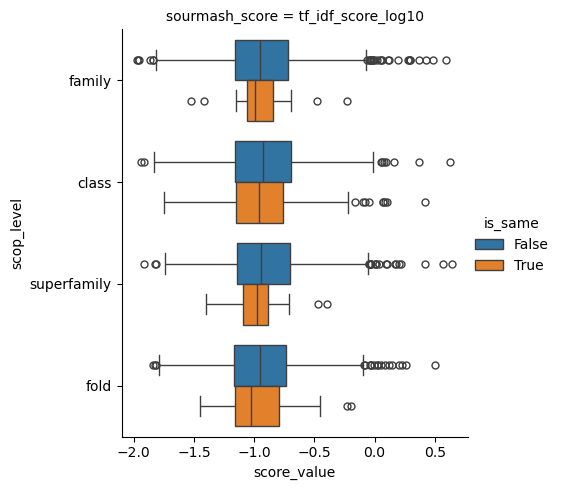

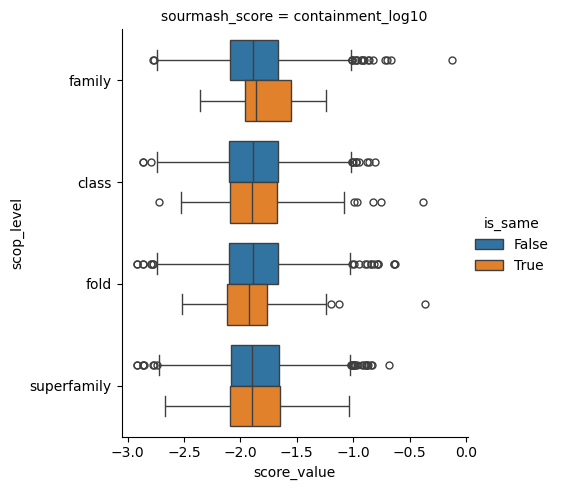

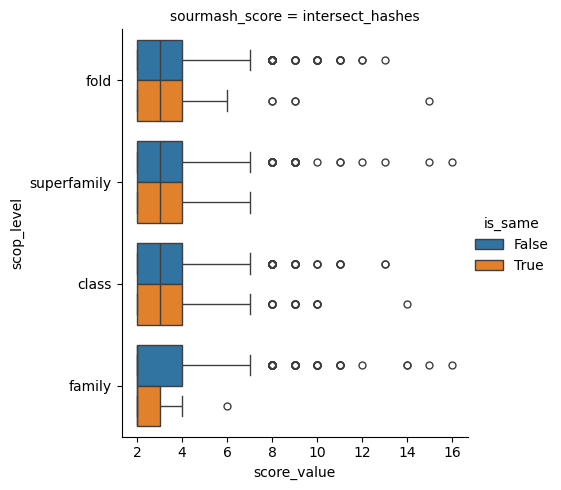

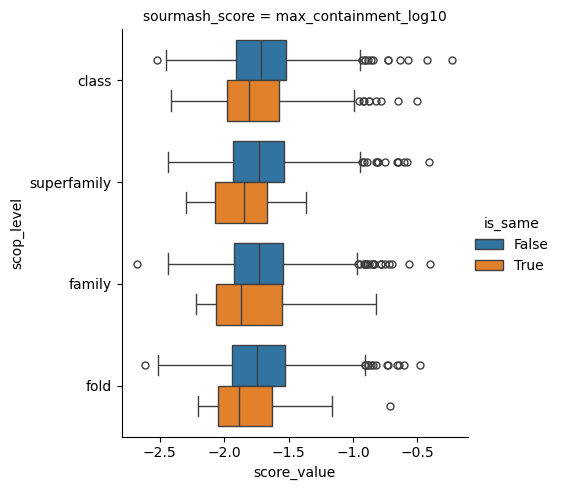

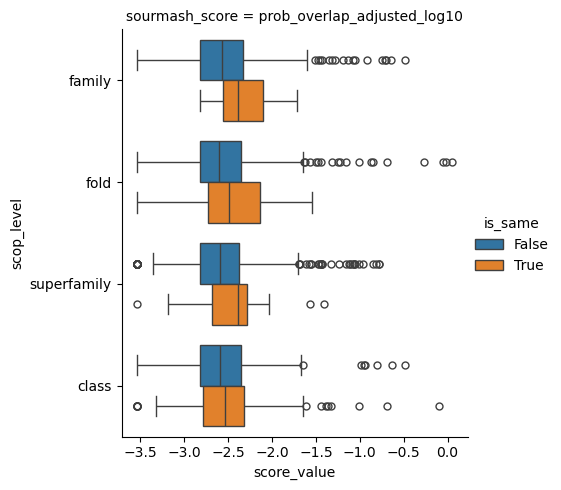

In [25]:
for sourmash_score, df in multisearch_melt_combined.group_by("sourmash_score"):
    print(f"--- {sourmash_score} ---")
    print(df.shape)
    sns.catplot(
        y="scop_level",
        x="score_value",
        hue="is_same",
        data=df.sample(10000),
        col="sourmash_score",
        sharey=False,
        dodge=True,
        kind="box",
    )

# Iterate over all protein benchmarks, randomly sampling 1000 queries to compare across moltypes and ksizes

In [27]:
randomly_chosen_queries = multisearch["query_name"].unique().sample(1000)
randomly_chosen_queries

query_name
str
"""d1pu1a_ d.266.1.1 (A:) Hypothe…"
"""d5cfja_ d.113.1.0 (A:) automat…"
"""d2bjia_ e.7.1.1 (A:) automated…"
"""d3is5a1 d.144.1.0 (A:130-395) …"
"""d4f2na1 a.2.11.0 (A:22-117) au…"
…
"""d2id0a4 b.40.4.16 (A:173-557) …"
"""d3mr7a1 d.58.29.0 (A:1-171) au…"
"""d1zh5a2 d.58.7.1 (A:104-189) L…"


In [ ]:
df.query("query_name in @randomly_chosen_queries")

In [39]:
same_lineage_cols

['same_family', 'same_superfamily', 'same_fold', 'same_class']

In [3]:
def make_multisearch_pq(
    analysis_outdir,
    moltype,
    ksize,
):
    basename = f"scope40.multisearch.{moltype}.k{ksize}.pq"
    pq = f"{analysis_outdir}/00_cleaned_multisearch_results/{basename}"
    return pq


moltype_info = {
    "protein": dict(
        ksizes=range(5, 21),
        pipeline_outdir="s3://seanome-kmerseek/scope-benchmark/pipeline-outputs/2024-10-08__protein_k5-20",
        analysis_outdir="s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__protein_k5-20",
    ),
    "dayhoff": dict(
        ksizes=range(5, 21),
        pipeline_outdir="s3://seanome-kmerseek/scope-benchmark/pipeline-outputs/2024-10-09__dayhoff_k5-20",
        analysis_outdir="s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__dayhoff_k5-20",
    ),
    "hp": dict(
        ksizes=range(20, 61),
        pipeline_outdir="s3://seanome-kmerseek/scope-benchmark/pipeline-outputs/2024-10-09__hp_k20-60",
        analysis_outdir="s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__hp_k20-60",
    ),
}


def add_log10_col(df, col):
    return df.with_columns(pl.col(col).log10().alias(f"{col}"))


def process_multisearch_results(analysis_outidr, moltype, ksize):
    pq = make_multisearch_pq(analysis_outdir, moltype, ksize)
    scanned = pl.scan_parquet(pq)
    df = scanned.filter(pl.col("query_name").is_in(randomly_chosen_queries)).collect()

    df = add_log10_col(df, "prob_overlap_adjusted")
    df = add_log10_col(df, "containment")
    df = add_log10_col(df, "max_containment")
    df = add_log10_col(df, "tf_idf_score")
    df = add_log10_col(df, "jaccard")

    melted = melt_sourmash_scop(df)

    melted = melted.with_columns(pl.lit(ksize).alias("ksize"))
    melted = melted.with_columns(pl.lit(moltype).alias("moltype"))
    return melted


def melt_sourmash_scop(
    df,
    same_lineage_cols=["same_family", "same_superfamily", "same_fold", "same_class"],
    sourmash_score_cols=[
        "containment_log10",
        "max_containment_log10",
        "jaccard_log10",
        "intersect_hashes",
        "containment_adjusted_log10",
        "tf_idf_score_log10",
        "prob_overlap_adjusted_log10",
    ],
):

    df_melt_scop_levels = df.unpivot(
        index=["query_name", "match_name"],
        on=same_lineage_cols,
        variable_name="scop_level",
        value_name="is_same",
    )
    df_melt_scop_levels = df_melt_scop_levels.with_columns(
        pl.col("scop_level").str.split("_").list.last().alias("scop_level")
    )

    df_melt_sourmash_score = df.unpivot(
        index=["query_name", "match_name"],
        on=value_cols_filtered,
        variable_name="sourmash_score",
        value_name="score_value",
    )
    melt_combined = df_melt_sourmash_score.join(
        df_melt_scop_levels, on=["query_name", "match_name"]
    )

    return melt_combined

    # print(multisearch_melt_sourmash_score.shape)
    # multisearch_melt_sourmash_score.head()


dfs = []

for moltype, info in moltype_info.items():
    ksizes = info["ksizes"]
    analysis_outdir = info["analysis_outdir"]
    print(f"moltype: {moltype}")
    for ksize in ksizes:
        try:
            df = process_multisearch_results(analysis_outdir, moltype, ksize)
            dfs.append(df)
        except pl.exceptions.ComputeError:
            pass

moltype: protein


NameError: name 'pl' is not defined

In [38]:
multisearch_moltype_ksize = pl.concat(dfs)
multisearch_moltype_ksize

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


query_name,query_md5,match_name,match_md5,containment,max_containment,jaccard,intersect_hashes,prob_overlap,prob_overlap_adjusted,containment_adjusted,containment_adjusted_log10,tf_idf_score,query_scop_id,query_scop_lineage,query_scop_lineage_fixed,query_family,query_superfamily,query_fold,query_class,match_scop_id,match_scop_lineage,match_scop_lineage_fixed,match_family,match_superfamily,match_fold,match_class,same_family,same_superfamily,same_fold,same_class,ksize,moltype
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,cat,cat,cat,cat,str,str,str,cat,cat,cat,cat,bool,bool,bool,bool,i32,str
"""d4j42a_ a.25.3.0 (A:) automate…","""76d0ac32d0304deac035bac144dca7…","""d4j42a_ a.25.3.0 (A:) automate…","""76d0ac32d0304deac035bac144dca7…",0.0,0.0,1.0,76.0,2.2493e-10,-1.285579,19.300971,1.285579,0.965548,"""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",true,true,true,true,5,"""protein"""
"""d6m4sa_ a.104.1.0 (A:) automat…","""c811c9cc918f2264bc8880ba9ecba2…","""d4j42a_ a.25.3.0 (A:) automate…","""76d0ac32d0304deac035bac144dca7…",-2.304275,-1.579784,0.004193,2.0,5.3112e-11,-1.912433,0.405656,-0.391842,-1.405083,"""d6m4sa_""","""a.104.1.0""","""a.104.1.0""","""a.104.1.0""","""a.104.1""","""a.104""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,false,true,5,"""protein"""
"""d4dnja_ a.104.1.0 (A:) automat…","""f4dc97f232fa0887e439b957585a2f…","""d4j42a_ a.25.3.0 (A:) automate…","""76d0ac32d0304deac035bac144dca7…",-2.596597,-1.880814,0.002128,1.0,8.4980e-12,-2.708313,1.293348,0.111715,-1.67075,"""d4dnja_""","""a.104.1.0""","""a.104.1.0""","""a.104.1.0""","""a.104.1""","""a.104""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,false,true,5,"""protein"""
"""d2cqza_ a.211.1.1 (A:) automat…","""672f4bdc36d23ed6bf17e5af387404…","""d4j42a_ a.25.3.0 (A:) automate…","""76d0ac32d0304deac035bac144dca7…",-2.227887,-1.880814,0.004098,1.0,1.1950e-12,-3.56025,21.496282,1.332363,-1.262153,"""d2cqza_""","""a.211.1.1""","""a.211.1.1""","""a.211.1.1""","""a.211.1""","""a.211""","""a""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,false,true,5,"""protein"""
"""d3l4ya1 b.30.5.0 (A:7-269) aut…","""6bc9adc30c845aaaa115e6910afa96…","""d4j42a_ a.25.3.0 (A:) automate…","""76d0ac32d0304deac035bac144dca7…",-2.4133,-1.880814,0.002994,1.0,4.7801e-12,-2.95819,3.506633,0.54489,-1.474695,"""d3l4ya1""","""b.30.5.0""","""b.30.5.0""","""b.30.5.0""","""b.30.5""","""b.30""","""b""","""d4j42a_""","""a.25.3.0""","""a.25.3.0""","""a.25.3.0""","""a.25.3""","""a.25""","""a""",false,false,false,false,5,"""protein"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""d1pt7a_ c.123.1.1 (A:) Hypothe…","""8bface18d61af7bc0550e13801b406…","""d1pt7a_ c.123.1.1 (A:) Hypothe…","""8bface18d61af7bc0550e13801b406…",0.0,0.0,1.0,356.0,9.6403e-11,-1.65354,45.033927,1.65354,0.997144,"""d1pt7a_""","""c.123.1.1""","""c.123.1.1""","""c.123.1.1""","""c.123.1""","""c.123""","""c""","""d1pt7a_""","""c.123.1.1""","""c.123.1.1""","""c.123.1.1""","""c.123.1""","""c.123""","""c""",true,true,true,true,60,"""hp"""
"""d3eeqa2 c.152.1.1 (A:10-214) C…","""febb8c1794d14052f82304b2447fed…","""d3eeqa2 c.152.1.1 (A:10-214) C…","""febb8c1794d14052f82304b2447fed…",0.0,0.0,1.0,146.0,3.9536e-11,-2.040637,109.808754,2.040637,0.997144,"""d3eeqa2""","""c.152.1.1""","""c.152.1.1""","""c.152.1.1""","""c.152.1""","""c.152""","""c""","""d3eeqa2""","""c.152.1.1""","""c.152.1.1""","""c.152.1.1""","""c.152.1""","""c.152""","""c""",true,true,true,true,60,"""hp"""
"""d1k6da_ c.124.1.2 (A:) Acetate…","""bf4c1ec3ff35aa54920ef2482149b4…","""d1k6da_ c.124.1.2 (A:) Acetate…","""bf4c1ec3ff35aa54920ef2482149b4…",0.0,0.0,1.0,160.0,4.3327e-11,-2.00087,100.200488,2.00087,0.997144,"""d1k6da_""

In [ ]:
# sns.catplot(x='ksize', y='', hue